# Appearance feature extraction with ResNet18

In [1]:
%load_ext autoreload
%autoreload 2

## Preparing the Bounding Boxes Dataset

In [2]:
from pathlib import Path

import soccertrack
from soccertrack import detection_model, Camera
from soccertrack.utils import get_git_root


root = get_git_root()

dataset_path = soccertrack.datasets.get_path("top-view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

frame_num = 0  # Frame number to extract features from
bbdf = soccertrack.load_df(path_to_csv)  # We will use this as ground truth
bbdf = bbdf.drop("3", level="TeamID", axis=1)  # Drop ball information

cam = Camera(path_to_mp4)  # Camera object will be used to load frames

dataset_root = Path(root) / "data" / "appearance_extractor"
trainset_path = Path(dataset_root) / "trainset"
valset_path = Path(dataset_root) / "valset"
testset_path = Path(dataset_root) / "testset"

dataset_paths = [trainset_path, valset_path, testset_path]


In [3]:
%%script false --no-raise-error # comment out this line to run this cell

import cv2

def crop_bbox(x, y, w, h, frame):
    return frame[y : y + h, x : x + w]

# extract bounding boxes from frame
for frame_num, frame in enumerate(cam.iter_frames()):

    for (team_id, player_id), bb in bbdf.get_frame(frame_num).iter_players():
        save_path = dataset_path / f"{team_id}/{player_id}_{frame_num}.png"
        
        bb = bb.astype(int).values[0]
        bbox_image = crop_bbox(*bb[:4], frame)

        if frame_num < 900 * 2 / 3:
            dataset_path = trainset_path
        elif frame_num < 900 * 5 / 6:
            dataset_path = valset_path
        else:
            dataset_path = testset_path

        save_path.parent.mkdir(parents=True, exist_ok=True)

        # save image to disk
        cv2.imwrite(str(save_path), bbox_image)

In [4]:
from seedir import seedir # This is a nice package for visualizing directory structures

seedir(dataset_root, itemlimit=3, sort=True)

appearance_extractor/
├─testset/
│ ├─0/
│ │ ├─1_750.png
│ │ ├─1_751.png
│ │ └─1_752.png
│ └─1/
│   ├─1_750.png
│   ├─1_751.png
│   └─1_752.png
├─trainset/
│ ├─0/
│ │ ├─1_0.png
│ │ ├─1_1.png
│ │ └─1_2.png
│ └─1/
│   ├─1_0.png
│   ├─1_1.png
│   └─1_2.png
└─valset/
  ├─0/
  │ ├─1_600.png
  │ ├─1_601.png
  │ └─1_602.png
  └─1/
    ├─1_600.png
    ├─1_601.png
    └─1_602.png


## Train the classifier

### 1. Create the DataModule

In [5]:
from soccertrack.image_model import ImageClassificationData

dm = ImageClassificationData(
    data_dir=dataset_root,
    batch_size=16,
)
dm.setup()

print(f'trainset: {len(dm.trainset)}')
print(f'valset: {len(dm.valset)}')
print(f'testset: {len(dm.testset)}')

im, label = dm.trainset[0]
print(f"image shape: {im.shape}, label: {label}")

trainset: 13205
valset: 3305
testset: 3300
image shape: torch.Size([3, 32, 32]), label: 0


### 2. Train the model

In [7]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

from soccertrack.image_model import ImageEmbedder

model = ImageEmbedder(num_classes=2)


save_path = get_git_root() / "appearance_extractor" / "resnet18"

# Save the best checkpoint based on the maximum val_acc recorded.
dirpath = get_git_root() / "models" / "resnet18" / "tutorial_results"
filename = '{epoch}-{val_acc:.2f}'
callbacks = [ModelCheckpoint(dirpath, filename, mode="max", monitor="val_acc"), RichProgressBar()]
trainer = pl.Trainer(
    default_root_dir=save_path,  # Where to save models
    max_epochs=1,  # How many epochs to train
    callbacks=callbacks, 
)

trainer.fit(model, dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/atom/Library/Caches/pypoetry/virtualenvs/soccertrack-KNSgM8DD-py3.9/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/atom/Github/SoccerTrack/models/resnet18 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name              ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ feature_extractor │ Sequential │ 11.2 M │
│ 1 │ classifier        │ Linear     │    130 │
└───┴───────────────────┴────────────┴────────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


In [8]:
trainer.test(model, dm)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9881818294525146     │
│         test_loss         │   0.042921021580696106    │
└───────────────────────────┴───────────────────────────┘
Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207/207 0:00:21 • 0:00:00 9.49it/s

[{'test_loss': 0.042921021580696106, 'test_acc': 0.9881818294525146}]

## Using the trained classifier as a feature extractor

In [13]:
from soccertrack.image_model import ImageEmbedder

ckpt_path = list(dirpath.glob('*.ckpt'))[-1]
model = ImageEmbedder.load_from_checkpoint(ckpt_path, num_classes=2)

model.eval()

x, y = dm.testset[0]
x = x.unsqueeze(0) # Add batch dimension

y_pred = model.predict(x)
y_emb = model(x, return_embeddings=True)

print(f"y_gt: {y}, y_pred: {y_pred}, y_emb: {y_emb.shape}")

y_gt: 0, y_pred: tensor([0]), y_emb: torch.Size([1, 64])


In [56]:
import torch
from soccertrack.logger import tqdm 

with torch.no_grad():
    embeddings, labels = zip(*[(model(b, return_embeddings=True), l) for b, l in tqdm(dm.test_dataloader())])

embeddings = torch.cat(embeddings)
labels = torch.cat(labels)

100%|██████████| 207/207 [00:43<00:00,  4.74it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3300 samples in 0.000s...
[t-SNE] Computed neighbors for 3300 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3300
[t-SNE] Computed conditional probabilities for sample 2000 / 3300
[t-SNE] Computed conditional probabilities for sample 3000 / 3300
[t-SNE] Computed conditional probabilities for sample 3300 / 3300
[t-SNE] Mean sigma: 0.735988
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.721603
[t-SNE] KL divergence after 300 iterations: 1.698035


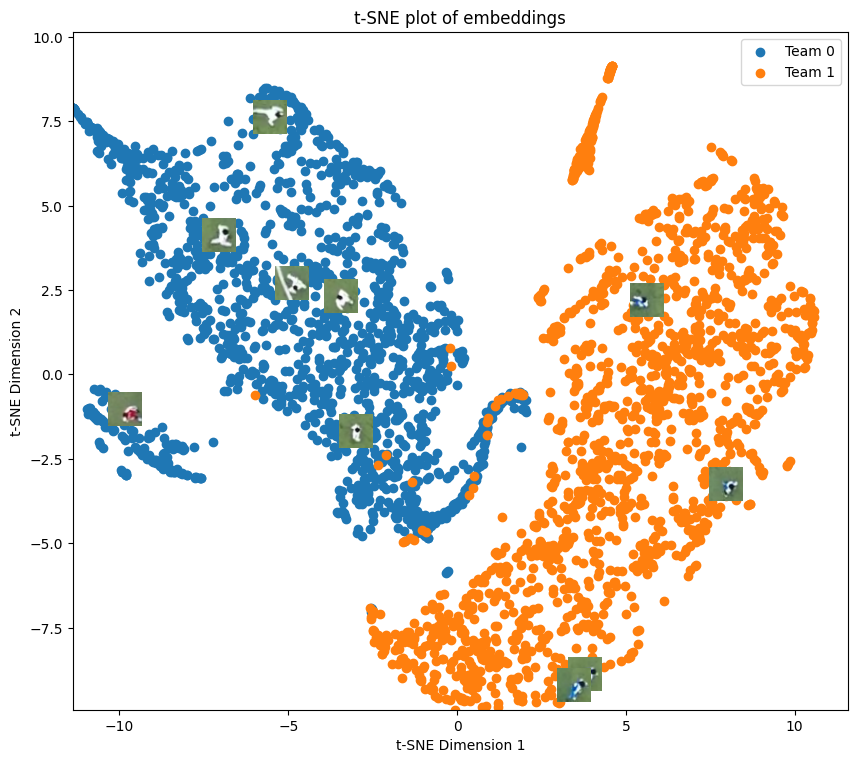

In [60]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch
from random import choice

# unnormalize the image
def unnormalize(im):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    im = im * std[:, None, None] + mean[:, None, None]
    return im.numpy().transpose(1, 2, 0)


# generate t-SNE embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# plot t-SNE results with ground truth labels and color by team
fig, ax = plt.subplots(figsize=(10, 10))

for team in [0, 1]:
    ax.scatter(
        tsne_results[labels == team, 0],
        tsne_results[labels == team, 1],
        c=f"C{team}",
        label=f"Team {team}",
    )

# set plot x and y limits
ax.set_xlim(tsne_results[:, 0].min(), tsne_results[:, 0].max() + 1)
ax.set_ylim(tsne_results[:, 1].min(), tsne_results[:, 1].max() + 1)
plt.title("t-SNE plot of embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# plot some images on top of the t-SNE plot
for i in np.random.choice(range(len(dm.testset)), size=10):
        data = dm.testset[i]
        data_input = data[0]# torch tensor
        data_input = unnormalize(data_input) # convert to numpy array
        data_target = data[1] # ground truth label
        data_emb = embeddings[i] # embedding
        
        # plot image at the embedding location
        ax.imshow(
            data_input,
            extent=(
                tsne_results[i, 0],
                tsne_results[i, 0] + 1,
                tsne_results[i, 1],
                tsne_results[i, 1] + 1,
            ),
            zorder=1,
        )

plt.legend()
plt.show()